Thank you for sharing submission and your way.

I appreciate all of you whose kernal is used by me.

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

# Preparing Data

In [2]:
#reduce the memory usage
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Loading & cleaning data

In [3]:
# using original data
root = Path('../input/ashrae-feather-format-for-fast-loading')
# train_df = pd.read_feather(root/'train.feather')
test_df = pd.read_feather(root/'test.feather')
building_meta_df = pd.read_feather(root/"building_metadata.feather")

In [4]:
# using LK data
leak_df = pd.read_feather('../input/ashrae-leak-data-station/leak.feather')
leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

In [5]:
print(leak_df.duplicated().sum())

0


In [6]:
print(leak_df.isnull().sum())

building_id      0
meter            0
meter_reading    0
timestamp        0
dtype: int64


In [7]:
gc.collect()

40

# Validation for models using leak data

In [8]:
!ls ../input/

ashrae-energy-prediction
ashrae-feather-format-for-fast-loading
ashrae-great-energy-predictor-iii-eda-model
ashrae-half-and-half
ashrae-highway-kernel-route4
ashrae-kfold-lightgbm-without-leak-1-08
ashrae-leak-data-station
ashrae-simple-data-cleanup-lb-1-08-no-leaks


In [9]:
kfold_submission = pd.read_csv('../input/ashrae-kfold-lightgbm-without-leak-1-08/submission.csv', index_col=0)
halfhalf_submission = pd.read_csv('../input/ashrae-half-and-half/submission.csv', index_col=0)
highway_submission = pd.read_csv('../input/ashrae-highway-kernel-route4/submission.csv', index_col=0)
gep3_submission = pd.read_csv("../input/ashrae-great-energy-predictor-iii-eda-model/Normal.csv", index_col=0)
simple_submission = pd.read_csv("../input/ashrae-simple-data-cleanup-lb-1-08-no-leaks/submission.csv", index_col=0)

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
test_df["pred1"] = kfold_submission.meter_reading
test_df["pred2"] = halfhalf_submission.meter_reading
test_df["pred3"] = highway_submission.meter_reading
test_df["pred4"] = gep3_submission.meter_reading
test_df["pred5"] = simple_submission.meter_reading

del kfold_submission, halfhalf_submission, highway_submission, gep3_submission
del simple_submission
gc.collect()

0

In [11]:
test_df.loc[test_df.pred3 < 0, "pred3"] = 0
test_df.loc[test_df.pred4 < 0, "pred4"] = 0
test_df.loc[test_df.pred5 < 0, "pred5"] = 0
test_df = reduce_mem_usage(test_df)
leak_df = reduce_mem_usage(leak_df)

Memory usage of dataframe is 2187.13 MB
Memory usage after optimization is: 1391.81 MB
Decreased by 36.4%
Memory usage of dataframe is 460.05 MB
Memory usage after optimization is: 276.03 MB
Decreased by 40.0%


In [12]:
test_df.head(10)

,row_id,building_id,meter,timestamp,pred1,pred2,pred3,pred4,pred5
0,0,0,0,2017-01-01,186.168106,92.729485,169.533401,162.409790,179.624802
1,1,1,0,2017-01-01,85.102570,41.220722,89.669403,78.838898,75.862000
2,2,2,0,2017-01-01,13.020658,2.686540,12.904300,8.548710,6.988500
3,3,3,0,2017-01-01,249.669037,139.413605,312.110107,216.632507,305.971710
4,4,4,0,2017-01-01,1130.942383,620.063782,1359.578369,1230.123779,1408.412231
5,5,5,0,2017-01-01,25.602278,4.611826,16.370600,12.909909,11.489800
6,6,6,0,2017-01-01,96.963814,60.395645,92.603699,99.529289,128.021393
7,7,7,0,2017-01-01,436.188873,101.772514,438.517395,413.543060,496.082092
8,8,7,1,2017-01-01,358.571686,60.734264,209.714996,412.859344,1035.932739
9,9,8,0,2017-01-01,318.887390,201.952988,347.813507,312.942200,435.761993


In [13]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred1', 'pred2', 'pred3', 'pred4', 'pred5', 'row_id']],
                        left_on = ['building_id','meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'],
                        how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')

In [14]:
leak_df["pred1_l1p"] = np.log1p(leak_df.pred1)
leak_df["pred2_l1p"] = np.log1p(leak_df.pred2)
leak_df["pred3_l1p"] = np.log1p(leak_df.pred3)
leak_df["pred4_l1p"] = np.log1p(leak_df.pred4)
leak_df["pred5_l1p"] = np.log1p(leak_df.pred5)
leak_df["meter_reading_l1p"] = np.log1p(leak_df.meter_reading)

In [15]:
leak_df.head(10)

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,pred4,pred5,row_id,site_id,pred1_l1p,pred2_l1p,pred3_l1p,pred4_l1p,pred5_l1p,meter_reading_l1p
0,0,0.0,173.370300,2017-01-01,186.168106,92.729485,169.533401,162.409790,179.624802,0,0,5.232007,4.540413,5.138931,5.096261,5.196422,5.161181
1,1,0.0,53.512718,2017-01-01,85.102570,41.220722,89.669403,78.838898,75.862000,1,0,4.455539,3.742911,4.507220,4.380011,4.342011,3.998434
2,2,0.0,6.143042,2017-01-01,13.020658,2.686540,12.904300,8.548710,6.988500,2,0,2.640532,1.304688,2.632198,2.256406,2.078003,1.966139
3,3,0.0,101.701469,2017-01-01,249.669037,139.413605,312.110107,216.632507,305.971710,3,0,5.524134,4.944592,5.746555,5.382808,5.726756,4.631826
4,4,0.0,1141.240723,2017-01-01,1130.942383,620.063782,1359.578369,1230.123779,1408.412231,4,0,7.031691,6.431434,7.215665,7.115683,7.250928,7.040747
5,5,0.0,13.651204,2017-01-01,25.602278,4.611826,16.370600,12.909909,11.489800,5,0,3.280997,1.724876,2.854779,2.632601,2.524912,2.684523
6,6,0.0,260.874512,2017-01-01,96.963814,60.395645,92.603699,99.529289,128.021393,6,0,4.584598,4.117339,4.539070,4.610449,4.859978,5.567865
7,7,0.0,502.705597,2017-01-01,436.188873,101.772514,438.517395,413.543060,496.082092,7,0,6.080365,4.632518,6.085677,6.027177,6.208755,6.221992
8,7,1.0,717.574036,2017-01-01,358.571686,60.734264,209.714996,412.859344,1035.932739,8,0,5.884913,4.122839,5.350506,6.025526,6.944022,6.577269
9,8,0.0,513.285278,2017-01-01,318.887390,201.952988,347.813507,312.942200,435.761993,9,0,5.767969,5.312974,5.854537,5.749209,6.079389,6.242778


In [16]:
leak_df.isnull().sum()

building_id          0
meter                0
meter_reading        0
timestamp            0
pred1                0
pred2                0
pred3                0
pred4                0
pred5                0
row_id               0
site_id              0
pred1_l1p            0
pred2_l1p            0
pred3_l1p            0
pred4_l1p            0
pred5_l1p            0
meter_reading_l1p    0
dtype: int64

In [17]:
print(leak_df[leak_df.pred1_l1p.isnull()])
print(leak_df[leak_df.pred4_l1p.isnull()])
print(leak_df[leak_df.pred5_l1p.isnull()])

Empty DataFrame
Columns: [building_id, meter, meter_reading, timestamp, pred1, pred2, pred3, pred4, pred5, row_id, site_id, pred1_l1p, pred2_l1p, pred3_l1p, pred4_l1p, pred5_l1p, meter_reading_l1p]
Index: []
Empty DataFrame
Columns: [building_id, meter, meter_reading, timestamp, pred1, pred2, pred3, pred4, pred5, row_id, site_id, pred1_l1p, pred2_l1p, pred3_l1p, pred4_l1p, pred5_l1p, meter_reading_l1p]
Index: []
Empty DataFrame
Columns: [building_id, meter, meter_reading, timestamp, pred1, pred2, pred3, pred4, pred5, row_id, site_id, pred1_l1p, pred2_l1p, pred3_l1p, pred4_l1p, pred5_l1p, meter_reading_l1p]
Index: []


In [18]:
del building_meta_df
gc.collect()

0

# Visualize

score1= 0.985471


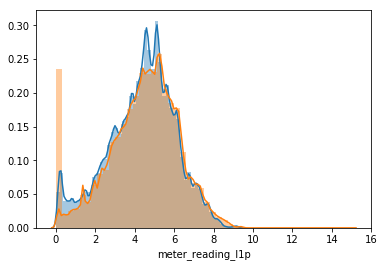

In [19]:
# kfold
sns.distplot(leak_df.pred1_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred1_l1p, leak_df.meter_reading_l1p))
print ('score1=', leak_score)

score2= 1.0053532


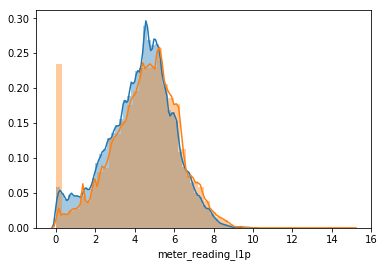

In [20]:
# half and half
sns.distplot(leak_df.pred2_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred2_l1p, leak_df.meter_reading_l1p))
print ('score2=', leak_score)

score3= 0.9965962


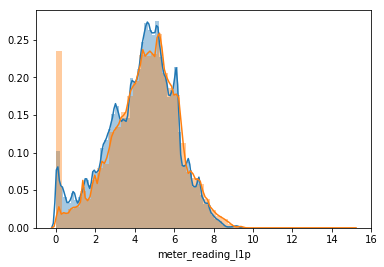

In [21]:
#highway route4
sns.distplot(leak_df.pred3_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred3_l1p, leak_df.meter_reading_l1p))
print ('score3=', leak_score)

score4= 0.9928892


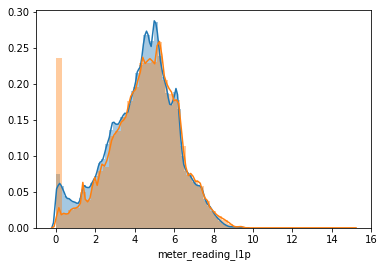

In [22]:
#gep3
sns.distplot(leak_df.pred4_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred4_l1p, leak_df.meter_reading_l1p))
print ('score4=', leak_score)

score5= 0.994212


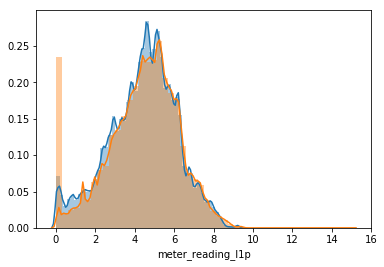

In [23]:
#simple_clean
sns.distplot(leak_df.pred5_l1p)
sns.distplot(leak_df.meter_reading_l1p)

leak_score = np.sqrt(mean_squared_error(leak_df.pred5_l1p, leak_df.meter_reading_l1p))
print ('score5=', leak_score)

# Find Best Weight

In [24]:
all_combinations = list(np.linspace(0.15,0.4,15))
all_combinations

[0.15,
 0.16785714285714284,
 0.18571428571428572,
 0.20357142857142857,
 0.22142857142857142,
 0.23928571428571427,
 0.2571428571428571,
 0.275,
 0.2928571428571428,
 0.3107142857142857,
 0.3285714285714285,
 0.3464285714285714,
 0.36428571428571427,
 0.3821428571428571,
 0.4]

In [25]:
import itertools

In [26]:
l = [all_combinations, all_combinations, all_combinations, all_combinations, all_combinations]
# all_l = list(itertools.product(*l)) + list(itertools.product(*reversed(l)))
all_l = list(itertools.product(*l))

In [27]:
gc.collect()

0

### filtering sumation of weight

In [28]:
filtered_combis = [l for l in all_l if l[0] + l[1] + l[2] + l[3] + l[4] > 0.95 and l[0] + l[1] + l[2] + l[3] + l[4] < 1.03]

In [29]:
print(len(filtered_combis))

11131


In [30]:
best_combi = [] # of the form (i, score)
for i, combi in enumerate(filtered_combis):
    #print("Now at: " + str(i) + " out of " + str(len(filtered_combis))) # uncomment to view iterations
    score1 = combi[0]
    score2 = combi[1]
    score3 = combi[2]
    score4 = combi[3]
    score5 = combi[4]
    v = score1 * leak_df['pred1'].values + score2 * leak_df['pred3'].values + score3 * leak_df['pred2'].values + score4 * leak_df['pred4'] + score5 * leak_df['pred5']
    vl1p = np.log1p(v)
    curr_score = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))
    
    if best_combi:
        prev_score = best_combi[0][1]
        if curr_score < prev_score:
            best_combi[:] = []
            best_combi += [(i, curr_score)]
    else:
        best_combi += [(i, curr_score)]
            
score = best_combi[0][1]
print(score)

0.9655607813591638


In [31]:
# test_df = pd.read_feather(root/'test.feather')
# kfold_submission = pd.read_csv('../input/ashrae-kfold-lightgbm-without-leak-1-08/submission.csv', index_col=0)
# halfhalf_submission = pd.read_csv('../input/ashrae-half-and-half/submission.csv', index_col=0)
# highway_submission = pd.read_csv('../input/ashrae-highway-kernel-route4/submission.csv', index_col=0)

# test_df["pred1"] = kfold_submission.meter_reading
# test_df["pred2"] = halfhalf_submission.meter_reading
# test_df["pred3"] = highway_submission.meter_reading

# del kfold_submission, halfhalf_submission, highway_submission
# gc.collect()

# test_df.loc[test_df.pred3 < 0, "pred3"] = 0
# test_df = reduce_mem_usage(test_df)

In [32]:
submission_form = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
final_combi = filtered_combis[best_combi[0][0]]
w1 = final_combi[0]
w2 = final_combi[1]
w3 = final_combi[2]
w4 = final_combi[3]
w5 = final_combi[4]
print("Best weight is w1(kfold):{}, w2(halfhalf):{}, w3(highway):{}, w4(gep3):{}, w5(simple):{}".format(w1, w2, w3, w4, w5))

submission_form['meter_reading'] = w1 * test_df.pred1 +  w2 * test_df.pred3  + w3 * test_df.pred2 + w4 * test_df.pred4 + w5 * test_df.pred5
submission_form.loc[submission_form.meter_reading < 0, 'meter_reading'] = 0

Best weight is w1(kfold):0.18571428571428572, w2(halfhalf):0.3285714285714285, w3(highway):0.15, w4(gep3):0.15, w5(simple):0.15


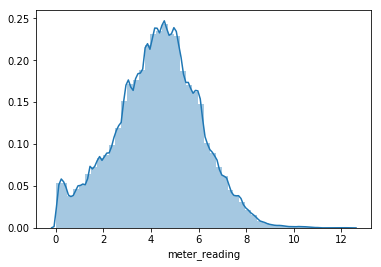

In [33]:
sns.distplot(np.log1p(submission_form.meter_reading))

In [34]:
gc.collect()

5

In [35]:
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
print(len(leak_df))

12059979


In [36]:
submission_form.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

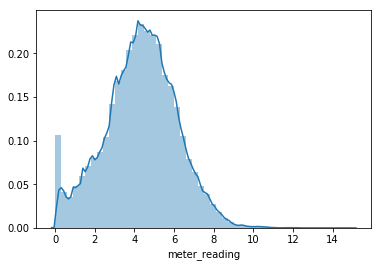

In [37]:
sns.distplot(np.log1p(submission_form.meter_reading))

In [38]:
gc.collect()

0

In [39]:
submission_form.to_csv('submission.csv', index=False, float_format='%.4f')